In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn as sns

In [2]:
# ---- load data saved from Julia ----
M = np.loadtxt("Data/M_shift.csv", delimiter=",", dtype=int)
X = np.loadtxt("Data/X_shift.csv", delimiter=",")
Y = np.loadtxt("Data/Y_shift.csv", delimiter=",")

# Make sure shapes are as expected
print("M shape:", M.shape)
print("X range:", X.min(), X.max())
print("Y range:", Y.min(), Y.max())

M_plot = M.copy()
M_plot[M_plot == 0] = 3   # <-- CHANGED: treat unclassified as blow-up


M shape: (300, 300)
X range: 0.0 6.0
Y range: -3.0 3.0


In [3]:
colors = [
    "#f0f0f0",  # 0: (unused now; could be anything)
    "#6a3d9a",  # 1: periodic - purple
    "#ff7f00",  # 2: fixed point - orange
    "#b2df8a",  # 3: blow-up - light green
    "#1f78b4",  # 4: quasi-periodic - blue
    "#e31a1c",  # 5: chaotic / irregular - red
]
cmap = mpl.colors.ListedColormap(colors)
bounds = np.arange(-0.5, 6.5, 1.0)  # boundaries between 0,1,...,5
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

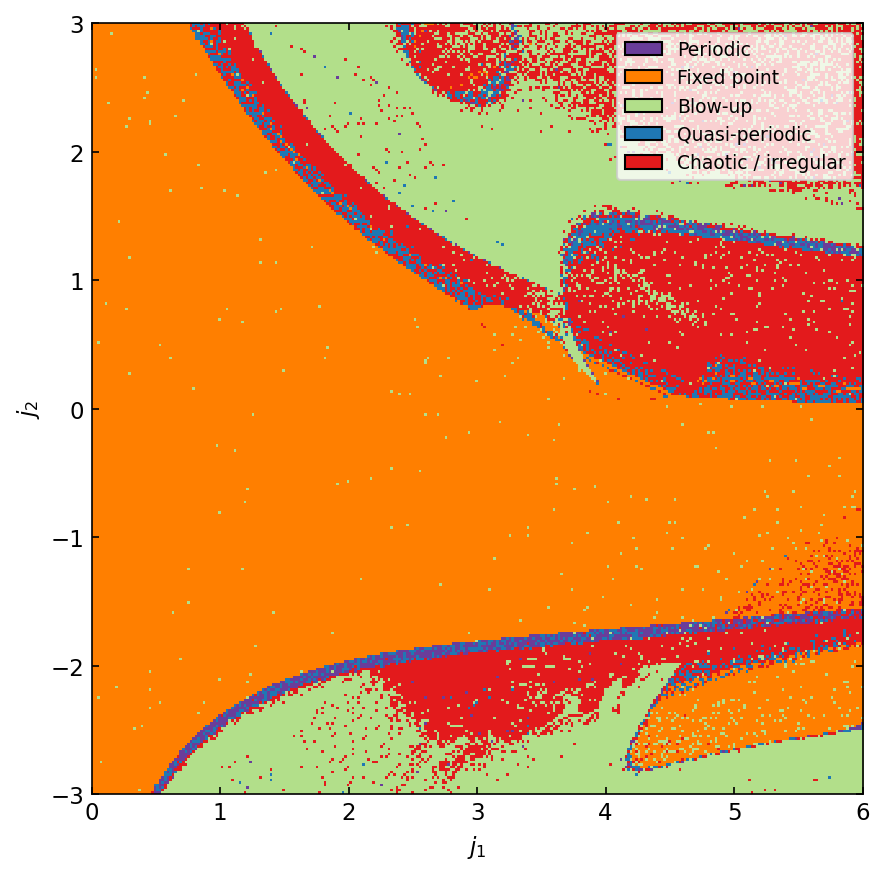

In [10]:
# ---- plotting ----
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

im = ax.imshow(
    M_plot,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    cmap=cmap,
    norm=norm,
    aspect="equal",
    interpolation="nearest",
)

ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$j_2$")

# ---- legend with semantic labels ----
legend_elements = [
    Patch(facecolor="#6a3d9a", edgecolor="k", label="Periodic"),
    Patch(facecolor="#ff7f00", edgecolor="k", label="Fixed point"),
    Patch(facecolor="#b2df8a", edgecolor="k", label="Blow-up"),
    Patch(facecolor="#1f78b4", edgecolor="k", label="Quasi-periodic"),
    Patch(facecolor="#e31a1c", edgecolor="k", label="Chaotic / irregular"),
]
ax.legend(
    handles=legend_elements,
    loc="upper right",
    frameon=True,
    fontsize=9,
)

# Optional: prettier ticks/fonts
ax.tick_params(direction="in", top=True, right=True)
mpl.rcParams["font.size"] = 11

fig.tight_layout()
fig.savefig("Plots/parameter_diagram_matplotlib(0-6).png", dpi=300, bbox_inches="tight")
fig.savefig("Plots/parameter_diagram_matplotlib(0-6).pdf", bbox_inches="tight")

plt.show()


In [4]:
# ---------- load data ----------
M = np.loadtxt("Data/M_LLE_shift.csv", delimiter=",")
X = np.loadtxt("Data/X_LLE_shift.csv", delimiter=",")
Y = np.loadtxt("Data/Y_LLE_shift.csv", delimiter=",")

# mask NaNs (unbound regions)
M_masked = np.ma.masked_invalid(M)

finite_vals = M_masked.compressed()
if finite_vals.size > 0:
    max_abs = np.max(np.abs(finite_vals))
else:
    max_abs = 1e-1

vmax = max_abs
vmin = -max_abs

/var/folders/5t/snj4wvpn3flbktmk6mzcd04w0000gn/T/ipykernel_60577/1337756869.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper right", frameon=True, fontsize=8)


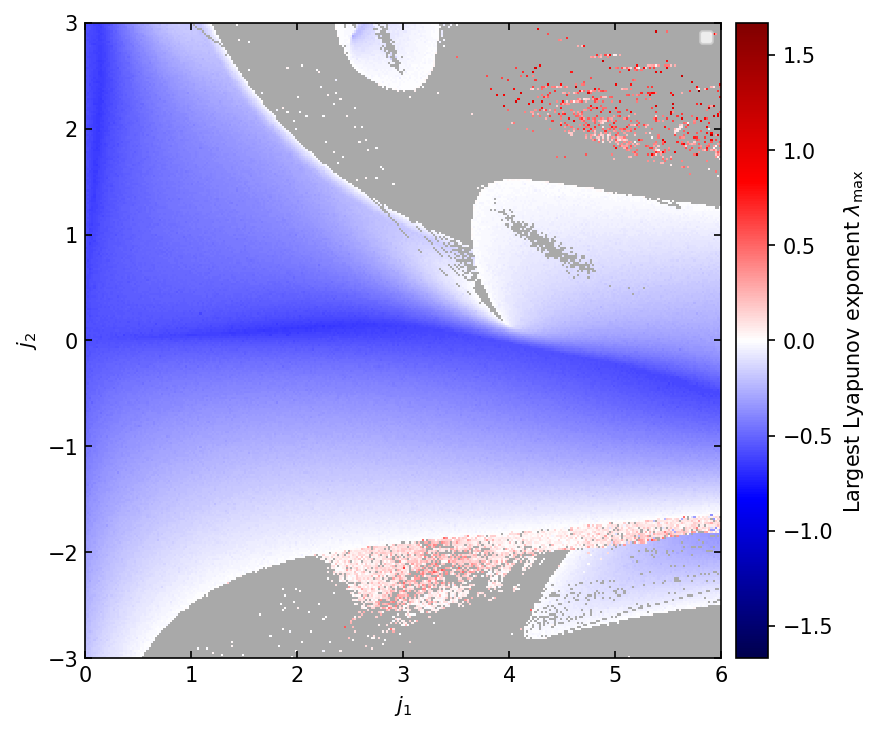

In [5]:
# ---------- plotting ----------
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

# diverging colormap centered at 0
cmap = plt.get_cmap("seismic").copy()
cmap.set_bad(color="darkgrey")  # NaNs (unbound) shown as light grey

im = ax.imshow(
    M_masked,
    origin="lower",
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    aspect="equal",
    cmap=cmap,
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
)

ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"$j_2$")

# Create a perfectly aligned colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = fig.colorbar(im, cax=cax)
cbar.set_label(r"Largest Lyapunov exponent $\lambda_{\max}$")

# diagonal line j1 = j2

# overlay periodic-ish points if files exist
try:
    px = np.loadtxt("periodic_px.csv", delimiter=",")
    py = np.loadtxt("periodic_py.csv", delimiter=",")
    if px.ndim == 0:  # single value edge case
        px = np.array([px])
        py = np.array([py])
    ax.scatter(
        px, py,
        s=10,
        color="orange",
        edgecolors="k",
        linewidths=0.3,
        label=r"$|\lambda_{\max}| < 10^{-3}$",
    )
except OSError:
    pass  # no periodic points file; just skip

ax.legend(loc="upper right", frameon=True, fontsize=8)
ax.tick_params(direction="in", top=True, right=True)
mpl.rcParams["font.size"] = 11

fig.tight_layout()
fig.savefig("Plots/lyapunov_map_(0-6).png", dpi=300, bbox_inches="tight")
fig.savefig("Plots/lyapunov_map_(0-6).pdf", bbox_inches="tight")

plt.show()


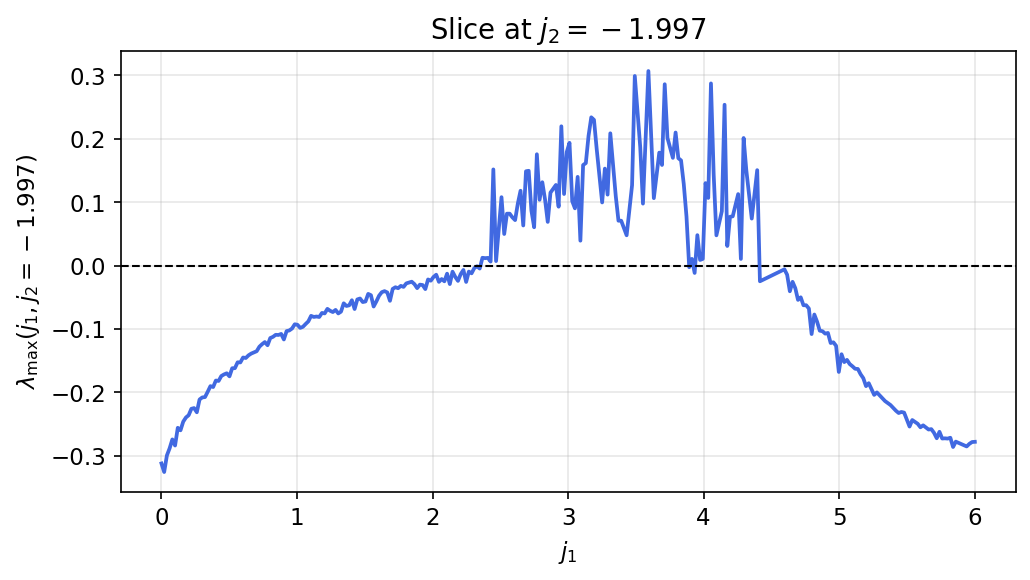

In [6]:
# ------------------------------------------------------
# 1D slice λ_max(j1, j2 = const)
# ------------------------------------------------------

j2_target = -2.0   # choose the value of j2 you want a slice at

# find closest index in the Y array
idx = np.argmin(np.abs(Y - j2_target))

# extract row idx
lambda_slice = M_masked[idx, :]   # shape: (Nx,)
j1_vals = X                        # shape: (Nx,)

# clean out NaNs
if hasattr(lambda_slice, "mask"):
    mask = ~lambda_slice.mask
    j1_clean = j1_vals[mask]
    lambda_clean = lambda_slice[mask]
else:
    j1_clean = j1_vals
    lambda_clean = lambda_slice

# ---- plotting ----
fig2, ax2 = plt.subplots(figsize=(7, 4), dpi=150)

ax2.plot(j1_clean, lambda_clean, linewidth=1.8, color="royalblue")
#ax2.scatter(j1_clean, lambda_clean, color="green", markersize = 0.5)
ax2.axhline(0, color='k', linestyle='--', linewidth=1)

ax2.set_xlabel(r"$j_1$")
ax2.set_ylabel(r"$\lambda_{\max}(j_1, j_2 = %.3f)$" % Y[idx])
ax2.set_title(r"Slice at $j_2 = %.3f$" % Y[idx])

ax2.grid(True, alpha=0.3)

fig2.tight_layout()
plt.show()


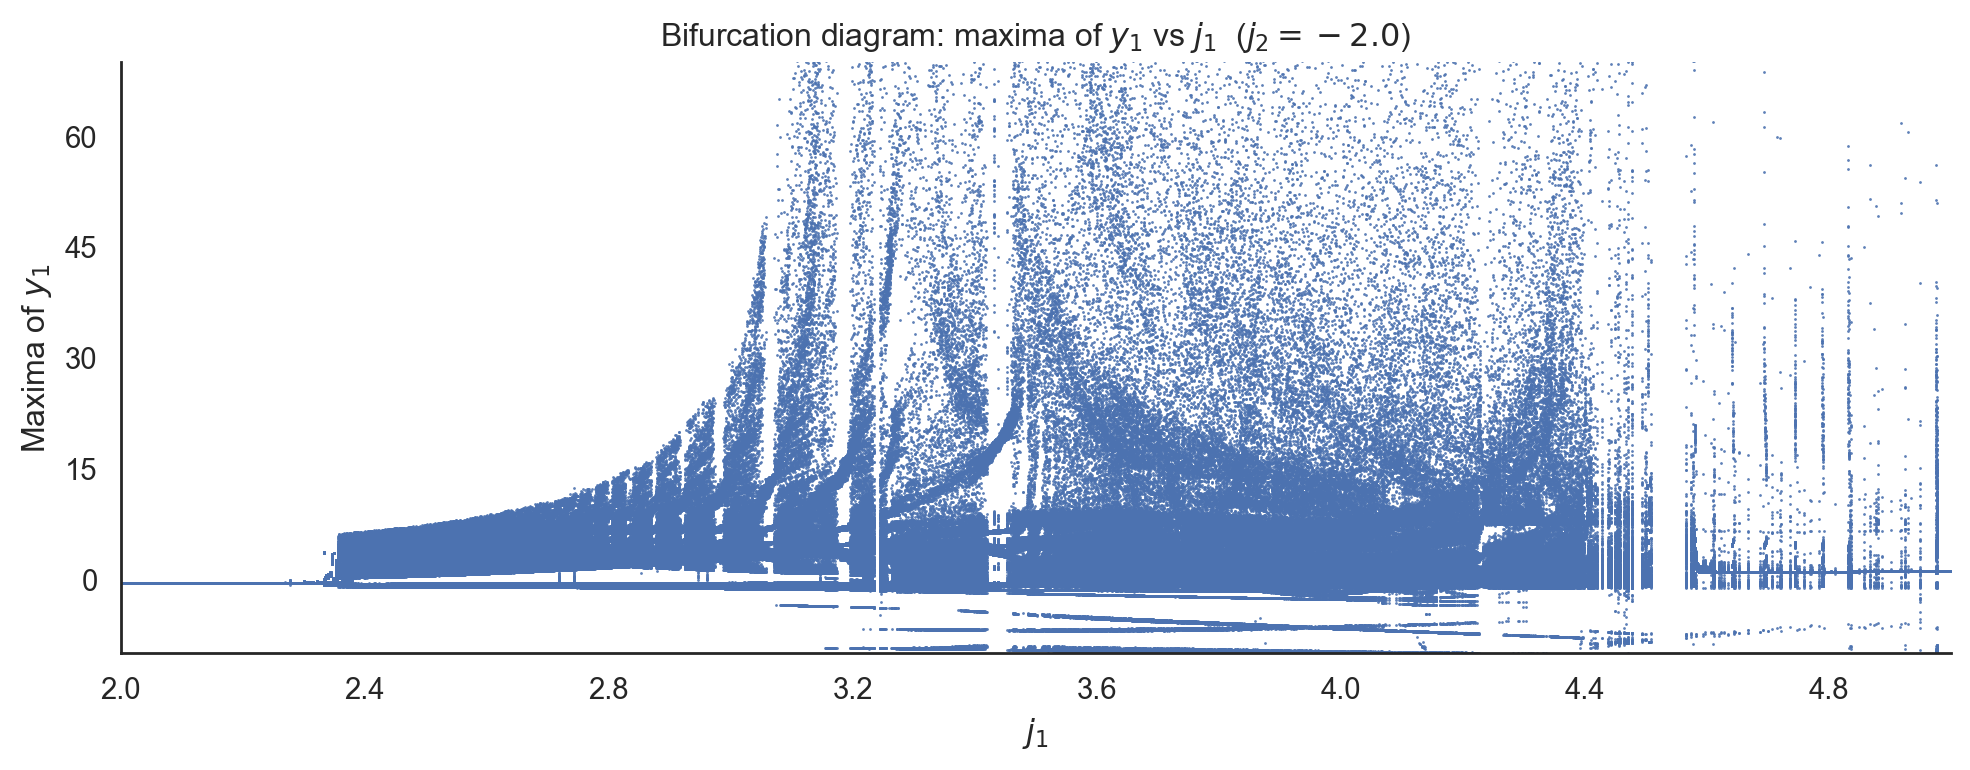

In [18]:

# ========== Config ==========
csv_path = "Data/bifurcation_data_j1_y1_j2_-2.0_(2-6).csv"
output_png = "Plots/bifurcation_j1_y1_j2_-2.0.png"
output_pdf = "Plots/bifurcation_j1_y1_j2_-2.0.pdf"

# Axis limits (adjust if needed)
x_min, x_max = 2, 5      # j1 range
y_min, y_max = -10.0,70.0    # expected maxima range

# ========== Load data ==========
df = pd.read_csv(csv_path)

# Optional: drop any NaNs just in case
df = df.dropna(subset=["j1", "max_y1"])

# ========== Style ==========
sns.set_theme(
    context="paper",            # smaller labels; use "talk" for presentations
    style="white",              # clean white background
    font_scale=1.2
)

# ========== Plot ==========
fig, ax = plt.subplots(figsize=(10, 4), dpi=200)  # wide aspect ratio

ax.scatter(
    df["j1"],
    df["max_y1"],
    s=1.0,              # very small markers for high-density plot
    linewidths=0,
    alpha=0.9,          # almost opaque; adjust if it’s too dense
)

ax.set_xlabel(r"$j_1$")
ax.set_ylabel(r"Maxima of $y_1$")
ax.set_title(r"Bifurcation diagram: maxima of $y_1$ vs $j_1$  ($j_2 = -2.0$)")

# Tight axis limits to your sweep
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Ticks: fine on x, coarser on y
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
ax.yaxis.set_major_locator(plt.MaxNLocator(6))

# Remove top/right spines for a clean look
sns.despine(ax=ax)

fig.tight_layout()

# Show and save
plt.show()
fig.savefig(output_png, dpi=300, bbox_inches="tight")
fig.savefig(output_pdf, bbox_inches="tight")
